Import necessary libaries

In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from collections import Counter
from wordcloud import WordCloud
import re
from unidecode import unidecode
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate,learning_curve,cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import SGDClassifier,SGDRegressor,LogisticRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pre-Processing

In [2]:
#Read csv files
train_data = pd.read_csv('./Data/train_set.csv')
test_data = pd.read_csv('./Data/test_set.csv')

#Create Dataframes
train_set = pd.DataFrame(train_data)
test_set = pd.DataFrame(test_data)

#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=labels_to_drop)

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)


Save Pre Processed Dataframe

In [5]:
train_set.to_csv('processed_df')
test_set.to_csv('processed_test')

Read Pre Processed Dataframe

In [3]:
data = pd.read_csv('processed_df')
train_set = pd.DataFrame(data)

data = pd.read_csv('processed_test')
test_set = pd.DataFrame(data)

Word Cloud

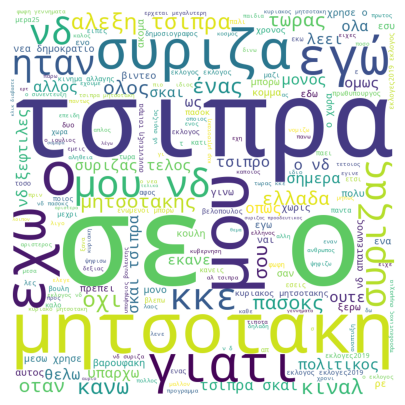

In [3]:
wordcloud = WordCloud(width=800, height=800,background_color='white').generate(' '.join(train_set['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Token Frequency

In [4]:
tokens = ' '.join(train_set['Text']).split()
token_counts = Counter(tokens)
print(token_counts.most_common(10))

[('ο', 18356), ('τσιπρα', 9690), ('νδ', 8170), ('μου', 8018), ('μητσοτακη', 7005), ('σε', 4527), ('εκλογος', 4325), ('εχω', 4212), ('συριζας', 4189), ('κκε', 3525)]


Text Length Distribution

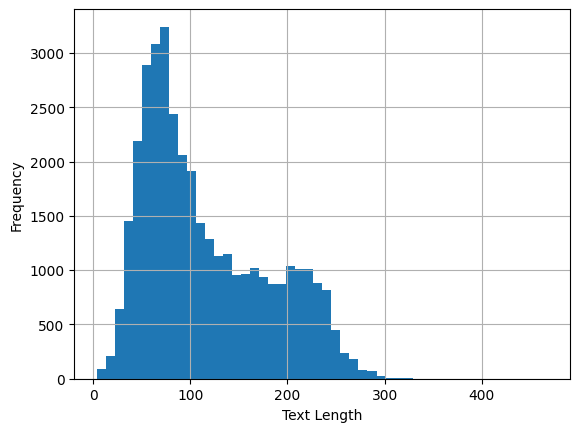

In [4]:
train_set['Text'] = train_set['Text'].apply(len)
train_set['Text'].hist(bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Vectorization and Label Encoding

In [13]:
vectorizer = CountVectorizer()
encoder = LabelEncoder()

#train_set = train_set.head(10000)


X_train = vectorizer.fit_transform(train_set['Text'])
X_test = vectorizer.fit_transform(test_set['Text'])

Y_train = encoder.fit_transform(train_set['Sentiment'])

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3)

Classification:

F1 Score Train: 1.0
F1 Score Validation: 0.3017541640617316
F1 Score Train: 0.9934336680450817
F1 Score Validation: 0.35538718232140426
F1 Score Train: 0.9842828984489154
F1 Score Validation: 0.3550177560411935
F1 Score Train: 0.9771932317625955
F1 Score Validation: 0.3544493374069464
F1 Score Train: 0.9708247327854126
F1 Score Validation: 0.35786663490460685
F1 Score Train: 0.9595247362809532
F1 Score Validation: 0.36232530546616043
F1 Score Train: 0.9554191077209462
F1 Score Validation: 0.3647638493067469
F1 Score Train: 0.9459790730192367
F1 Score Validation: 0.363266715418247
F1 Score Train: 0.9390991558298549
F1 Score Validation: 0.36530746823440435
F1 Score Train: 0.9336893087960098
F1 Score Validation: 0.36702569388276773
0.9659445912689006
0.3547164107044209


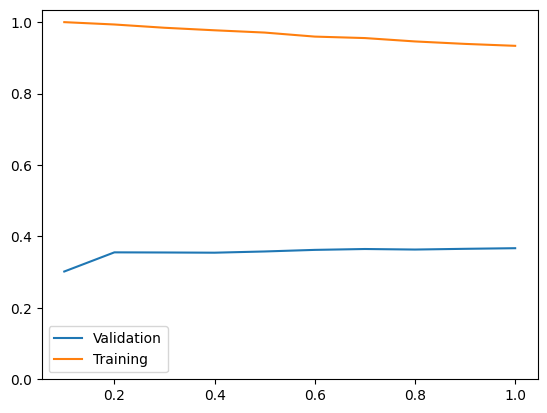

In [14]:
list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(X_train, Y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(max_iter=2000,C=100.0,multi_class='auto',solver='lbfgs')
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  #
  results = classifier.predict(X_val)

  # score
  #
  f1_train = f1_score(y, results_train,average='weighted')
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_val, results,average='weighted')
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

print(sum(list_f1_train) / len(list_f1_train))
print(sum(list_f1) / len(list_f1))

Logistic Regression Classifier

$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Penalty} & \text{C} & \text{Multi Class} & \text{Max Iterations} & \text{Solver} & \text{Avg F1-Score}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{100} & \text{lbfgs} & \text{35.6\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{500} & \text{lbfgs} & \text{35.9\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{1000} & \text{lbfgs} & \text{34.9\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{36.1\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.2\%}\\
\hline
\text{L2} & \text{5.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.9\%}\\
\hline
\text{L2} & \text{10.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.2\%}\\
\hline
\text{L2} & \text{20.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{34.9\%}\\
\hline
\text{L2} & \text{100.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.4\%}\\
\hline
\end{array}
$
$$ $$
C > 10.0 ,really great f1 training values > 0.95 but really long time to execute. $$ $$
C = 100.0 took : 4 minutes 1 seconds with avg training f1: 96.5% but only 35.4% avg f1 test.$$ $$
C < 1.0,good f1 validation score but low training f1